In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Rose', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

No dat file found, not loading
filename: /Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 17308.23 seconds 
duration: 4.81 hours 



## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/Users/nkinsky/Documents/UM/GitHub/TraceFC/Notebooks/Sync_USV_and_Ephys.ipynb saved to /Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_Sync_USV_and_Ephys.ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 14.1 seconds


,start,stop,label,duration
0,939.1648,940.4816,,1.3168
1,1104.0216,1105.3240,,1.3024
2,1390.1032,1391.6128,,1.5096
3,1655.8784,1657.1640,,1.2856
4,1911.5200,1912.9360,,1.4160
5,2180.3384,2182.1096,,1.7712
6,2621.1736,2621.6496,,0.4760
7,2831.7920,2832.9784,,1.1864
8,8877.4024,8877.8432,,0.4408
9,8890.2336,8891.9280,,1.6944


<Axes: >

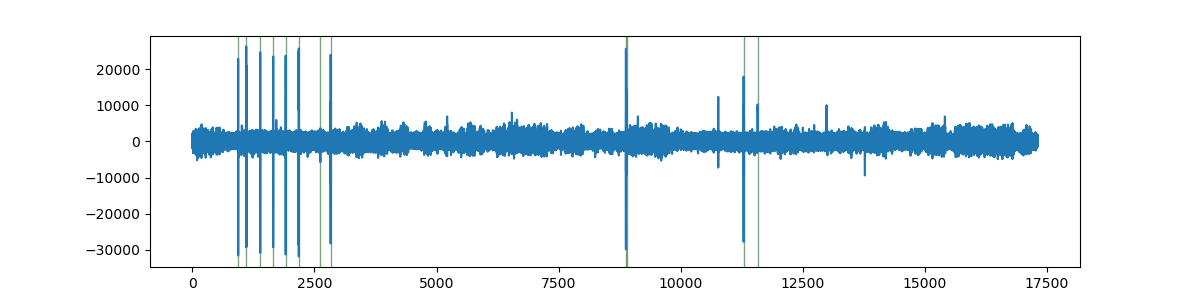

In [7]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.probegroup.npy saved


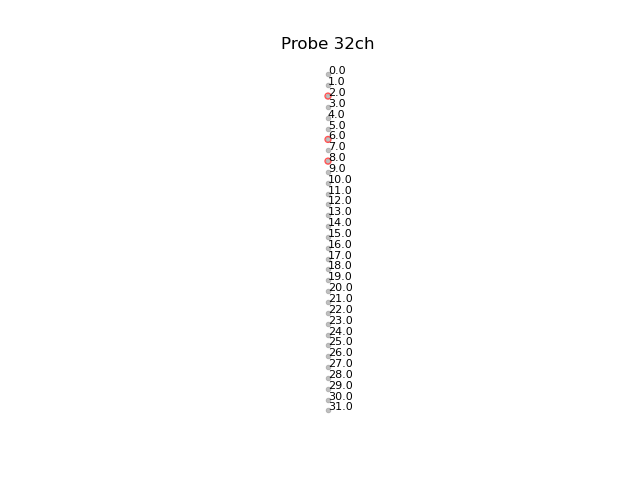

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
# from neuropy.analyses.oscillations import detect_theta_epochs
# mindur=1
# maxdur=20
# thresh = (1, None)
# sigma = 0.125
# edge_cutoff = 0.25
# theta_channel = 25

# # use this if you don't know theta channel
# if theta_channel is None:
#     theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
#                                                     edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
# else:
#     signal_use = signal.time_slice(channel_id=theta_channel)
#     theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
#                                                     edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

## Detect SWR Epochs

In [10]:
# from neuropy.analyses.oscillations import detect_ripple_epochs
# ripple_channel = 25
# thresh = (2, None)  # conservative but good
# edge_cutoff = 0.5
# ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
#                                      ignore_epochs=art_epochs)


## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

In [11]:
# Load in csv files with CS timing info (rough datetimes only) + OpenEphys recording times
from tracefc.io.traceio import TraceSync

trace_sync = TraceSync(sess.basepath)

OpenEphys recording times
start time = 2022-06-22 12:13:44.331483-04:00
start time = 2022-06-22 12:25:48.054692-04:00
start time = 2022-06-22 12:35:27.787169-04:00

5 CS- events detected
      Time (s)      Event                     Timestamp
5    61.596351  CS1_start 2022-06-22 12:15:01.388465908
7   141.519783  CS2_start 2022-06-22 12:16:21.311898497
9   216.400418  CS3_start 2022-06-22 12:17:36.192532566
11  294.323995  CS4_start 2022-06-22 12:18:54.116109637
13  369.173884  CS5_start 2022-06-22 12:20:08.965999153

6 CS+ events detected
       Time (s)      Event                     Timestamp
6    365.882572  CS1_start 2022-06-22 12:32:07.500386412
16   625.274096  CS2_start 2022-06-22 12:36:26.891909535
26   911.356316  CS3_start 2022-06-22 12:41:12.974130090
36  1177.138896  CS4_start 2022-06-22 12:45:38.756710465
46  1432.760581  CS5_start 2022-06-22 12:49:54.378395493
56  1701.590045  CS6_start 2022-06-22 12:54:23.207858737


      channel_states  timestamps                     datetimes event_name
913                2     2311926 2022-06-22 12:15:01.064199999           
1061              -2     2609310 2022-06-22 12:15:10.977000000           
2101               2     4709635 2022-06-22 12:16:20.987833333           
2249              -2     5007793 2022-06-22 12:16:30.926433333           
3214               2     6956054 2022-06-22 12:17:35.868466667           


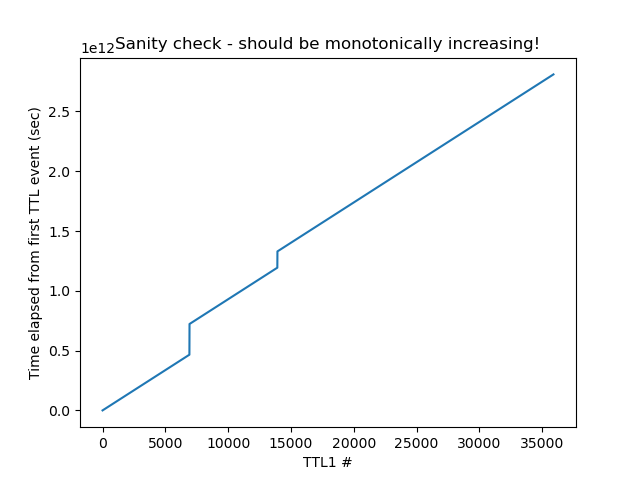

In [12]:
# Load in ttl events from OpenEphys
trace_sync.load_ttls()

In [22]:
# Align CS times from CSV to OpenEphys for exact timing
trace_sync.all_cs_to_oe()

CS lag times
TTL to CSV lag: mean = -0.6511317885, std = 0.29458161267510247
TTL to CSV lag: mean = -0.6514769363333334, std = 0.294484481800417
cs_oe_df already created for all event types - nothing ran
CSN lag times
TTL to CSV lag: mean = -0.3240611524, std = 0.0001311151501803072
TTL to CSV lag: mean = -0.3244041842, std = 0.00014620361483801467
cs_oe_df already created for all event types - nothing ran


/Users/nkinsky/Documents/UM/GitHub/TraceFC/tracefc/io/traceio.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Localize time to recording location in case recorded in different zone (e.g., UTC)
/Users/nkinsky/Documents/UM/GitHub/TraceFC/tracefc/io/traceio.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Localize time to recording location in case recorded in different zone (e.g., UTC)
/Users/nkinsky/Documents/UM/GitHub/TraceFC/tracefc/io/traceio.py:280: SettingWithCopyWarning: 
A value is tryi

,level_0,index,channel_states,timestamps,datetimes,event_name,eeg_time,label
0,0,913,2,2311926,2022-06-22 12:15:01.064199999-04:00,,76.732716,csn_start
1,1,1061,-2,2609310,2022-06-22 12:15:10.977000-04:00,,86.645517,csn_stop
2,2,2101,2,4709635,2022-06-22 12:16:20.987833333-04:00,,156.656350,csn_start
3,3,2249,-2,5007793,2022-06-22 12:16:30.926433333-04:00,,166.594950,csn_stop
4,4,3214,2,6956054,2022-06-22 12:17:35.868466667-04:00,,231.536983,csn_start
5,5,3363,-2,7254179,2022-06-22 12:17:45.805966667-04:00,,241.474483,csn_stop
6,6,4373,2,9293766,2022-06-22 12:18:53.792200-04:00,,309.460717,csn_start
7,7,4521,-2,9591164,2022-06-22 12:19:03.705466667-04:00,,319.373983,csn_stop
8,8,5485,2,11539260,2022-06-22 12:20:08.642000-04:00,,384.310517,csn_start
9,9,5634,-2,11837250,2022-06-22 12:20:18.575000-04:00,,394.243517,csn_stop


### How to write CS+ to neuroscope event file

In [33]:
cs_tone_recall_epochs = trace_sync.to_epochs('cs')
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [ ]:
# Detect CS+ in audio recording.
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs, cs_wav_stop = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", 
                                         plot_check=True, return_stop=True)
# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

In [ ]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, "csn")
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", 
                                           plot_check=True, return_stop=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

In [ ]:
no_tone_wave = grab_usv_folder(sess.basepath, "sync")
print(no_tone_wav)

# Get CS+ times and plot to check
start_wav_epochs, start_wav_stop = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=3, tone_length=0.5, tone_label="start_tone", 
                               plot_check=True, return_stop=True)

## Sync recorded USV times to ephys file

In [ ]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csp_wav).parent.glob(f"**/{Path(csp_wav).name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df.sample(5)

Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

In [ ]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '*-')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [ ]:
def get_wav_to_dat_equation(cs_wav_epochs, cs_start_lags, cs_stop_lags, sync_df):
    """Get equation to convert cs times to dat file times"""
    pass
    # 1) Get rough alignment by identifying FIRST tone and getting datetime for each tone

    # 2) Identify any disconnect times and split into epochs of continuous recording

    # 3) Call function recursively for each epoch

    # 4) Fit a line to the lag data - in the case that there is only one point, return a Nan

    # 5) Go back and re-fit any NaN epochs using the mean slope from another epoch

    # 6) Return a dataframe with epoch start stop (from sync file) + appropriate slope and intercept to use!
    

In [ ]:
def sync_rec_to_eeg(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp):
    """Get start and stop times of outside recording in eeg time"""
    # ID which eeg recordings the external recording spanned.
    start_stop_long = np.array([rec_start.to_datetime64().astype("long"), 
                                rec_stop.to_datetime64().astype("long")])
    sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
    indx_bool, t, _, bin_loc = sync_dt_epochs.contains(start_stop_long, return_closest=True)
    rec_span = (bin_loc/2).astype(int)

    # Identify overall start and stop time of external recording
    eeg_start_stop = []
    for t_interp, nrec in zip(start_stop_long, rec_span):
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        eeg_time_interp = np.interp(t_interp, 
                                   [start_df.Datetime.values[0].astype("long"), stop_df.Datetime.values[0].astype("long")],
                                   [start_df.eeg_time.values[0], stop_df.eeg_time.values[0]])
        eeg_start_stop.append(eeg_time_interp)

    eeg_start_stop = np.array(eeg_start_stop)

    return eeg_start_stop, rec_span
        

    
sync_rec_to_eeg(sync_df, wav_start_rough, wav_stop_rough)  
    

In [ ]:
def external_rec_sync_df(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp, rec_str="rec"):
    """Create dataframe identifying the start and stop times in the external file corresponding to eeg recording times."""

    # Get recording start and stop times in long format
    rec_start_stop_long = [rec_start.to_datetime64().astype("long"), rec_stop.to_datetime64().astype("long")]

    # Figure out start and stop times in eeg file time
    eeg_start_stop, rec_span = sync_rec_to_eeg(sync_df, rec_start, rec_stop)

    # Loop through and find start/stop of external recording that corresponds to eeg file times.
    rec_start_stops_all, eeg_start_stops_all = [], []
    eeg_recs = np.arange(rec_span[0], rec_span[1] + 1)
    for nrec in eeg_recs:
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
    
        # Get legit external recording times corresponding to eeg times in long datetime format
        nrec_epoch_start = np.max((rec_start, pd.Timestamp(start_df.Datetime.iloc[0])))
        nrec_epoch_stop = np.min((rec_stop, pd.Timestamp(stop_df.Datetime.iloc[0])))
        nrec_start_stop_long = [nrec_epoch_start.to_datetime64().astype("long"),
                               nrec_epoch_stop.to_datetime64().astype("long")]
    
        # Get corresdonding eeg file times
        nrec_eeg_start = start_df.eeg_time.values[0]
        nrec_eeg_stop = stop_df.eeg_time.values[0]
        nrec_eeg_start_stop = [nrec_eeg_start, nrec_eeg_stop]
        eeg_start_stops_all.append(nrec_eeg_start_stop)
    
        # Grab wav file start and stops
        rec_start_stops = np.interp(nrec_start_stop_long, rec_start_stop_long, [0, rec_dur])
        rec_start_stops_all.append(rec_start_stops)
        
    eeg_start_stops_all = np.array(eeg_start_stops_all)
    rec_start_stops_all = np.array(rec_start_stops_all)
    
    return pd.DataFrame({"nrec": eeg_recs, "eeg_start": eeg_start_stops_all[:, 0], "eeg_stop": eeg_start_stops_all[:, 1],
                        f"{rec_str}_start": rec_start_stops_all[:, 0], f"{rec_str}_stop": rec_start_stops_all[:, 1]})
    
rec_start, rec_stop = wav_start_rough, wav_stop_rough
external_rec_sync_df(sync_df, rec_start, rec_stop, "wav")

In [ ]:
wav_rough_start = cs_oe_start_df.iloc[0].datetimes - pd.Timedelta(cs_times_wav[0][0], 'seconds')
print(wav_rough_start)
wav_rough_stop = wav_rough_start + pd.Timedelta(cs_wav_stop, 'seconds')
print(wav_rough_stop)

In [ ]:
# Reshape inputs
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)

def fit_line_to_lags(times_wav, oe_lags_comb, use_slope=-0.0001687172):

    if times_wav.shape[0] > 1:
        # Fit function to approximate drift
        y = oe_lags_comb.T.reshape(-1)
        M = np.stack((np.ones_like(oe_lags_comb.reshape(-1)), times_wav.T.reshape(-1)), axis=1)
        p, res, rnk, s = lstsq(M, y)

    else:
        if use_slope is None:
            p = np.nan
        else:
            p1 = use_slope
            p0 = oe_lags_comb.mean() - p1 * times_wav.mean()
            p = (p0, p1)

    return p

# 2) Identify roughly where each tone occurred
sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
indx_bool, _, _ = sync_dt_epochs.contains(cs_oe_start_df.datetimes.values.astype("long"))
rec_number = (np.digitize(cs_oe_start_df.datetimes.values.astype("long")[indx_bool], sync_dt_epochs.flatten()) - 1) /2
rec_number = rec_number[indx_bool].astype(int)
rec_numbers = np.unique(rec_number)
nepochs = len(rec_numbers)

# wav_start_rough =  

# 3-4) Call each session and fit a line
p_list = []
for nrec in np.unique(rec_number):
    p_list.append(fit_line_to_lags(cs_times_wav[rec_number == nrec], cs_lags_comb[rec_number == nrec]))
p_bool = np.array([~np.all(np.isnan(p)) for p in p_list])
pid_good = np.where(p_bool)[0]
pid_bad = np.where(~p_bool)[0]
slope_use = np.nanmean([p if np.all(np.isnan(p)) else p[1] for p in p_list])

# 5) Go back and refit
p_list_refit = []
wav_starts, wav_stops = [], []
for pid in np.unique(rec_number):

    # Get fits for each ephys recordings number
    if (pid + 1) in pid_good:  # use existing line values if good fit to begin with and > 2 points
        p_list_refit.append(p_list[pid])
    else:
        p_list_refit.append(fit_line_to_lags(cs_times_wav[rec_number == pid], cs_lags_comb[rec_number == pid], use_slope=slope_use))
    p_refit = np.array(p_list_refit)


# 6) Get df of wav starts and stops
rec_rough_start = cs_oe_start_df.iloc[0].datetimes - pd.Timedelta(cs_times_wav[0][0], 'seconds')
rec_rough_stop = wav_rough_start + pd.Timedelta(cs_wav_stop, 'seconds')
wav_sync_df = external_rec_sync_df(sync_df, rec_rough_start, rec_rough_stop, "wav")

# 7) Add in slopes
wav_sync_df = wav_sync_df.merge(pd.DataFrame({"nrec": np.unique(rec_number), "p0": p_refit[:, 0], "p1": p_refit[:, 1]}))

wav_sync_df

In [ ]:
_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '-*')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
for nrec in [1, 2]:
    
    wav_times = wav_sync_df.loc[wav_sync_df.nrec == nrec, ["wav_start", "wav_stop"]].values.squeeze()
    hfit = ax.plot(wav_times, wav_sync_df[wav_sync_df.nrec == nrec].p0.values + 
                   wav_sync_df[wav_sync_df.nrec == nrec].p1.values*wav_times, 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [ ]:
def get_rec_num(rec_sync_df, times):
    """Identify in which recording each time in times occurs"""
    bin_loc = np.digitize(times, rec_sync_df.loc[:, ["wav_start", "wav_stop"]].values.flatten("C"))
    indx_bool = bin_loc % 2 == 1
    
    indx_bool = bin_loc % 2 == 1
    indx_good = np.where(indx_bool)
    indx_bad = np.where(~indx_bool)
    
    nrec_ids = np.ones_like(indx_bool, dtype='int')
    bin_ind = (bin_loc / 2).astype(int)
    if np.any(indx_good):
        nrec_ids[indx_good] = rec_sync_df.loc[bin_ind[indx_good], "nrec"].values
    
    if np.any(indx_bad):
        nrec_ids[indx_bad] = -1

    
    return nrec_ids

get_rec_num(wav_sync_df , cs_wav_epochs.starts)

In [ ]:
from copy import deepcopy
def wav_epochs_to_eeg(wav_epochs_df, wav_sync_df):
    """wav_epochs_df must have start and stop field for each index"""
    wav_epochs_df2 = deepcopy(wav_epochs_df)
    nrec_start = get_rec_num(wav_sync_df, wav_epochs_df2.start)
    nrec_stop = get_rec_num(wav_sync_df, wav_epochs_df2.stop)
    nrec_bool = nrec_start == nrec_stop
    nrec_good = np.ones_like(nrec_start)*-1
    nrec_good[nrec_bool] = nrec_start
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], column="nrec", value=nrec_good)
    t_starts, t_stops = [], []
    for it in wav_epochs_df2.itertuples():
        p_use = wav_sync_df.loc[wav_sync_df.nrec == it.nrec, ["p0", "p1"]].values.squeeze()
        t_start = it.start + p_use[0] + p_use[1]*it.start
        t_stop = it.stop + p_use[0] + p_use[1]*it.stop
        t_starts.append(t_start)
        t_stops.append(t_stop)
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_start_eeg", t_starts)
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_stop_eeg", t_stops)
    
    return wav_epochs_df2

wav_epochs_to_eeg(cs_wav_epochs.to_dataframe(), wav_sync_df)

In [ ]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_epochs_aligned = wav_epochs_to_eeg(cs_wav_epochs.to_dataframe(), wav_sync_df)
cs_wav_epochs_aligned = Epoch({"start": cs_wav_epochs_aligned.t_start_eeg.values, 
                               "stop": cs_wav_epochs_aligned.t_stop_eeg.values, 
                               "label": ["CS+ from WAV file"]*cs_wav_epochs_aligned.shape[0]})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

## Now correct that drift and find corrected lags!

In [ ]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
calls_accept_df = wav_epochs_to_eeg(calls_accept_df, wav_sync_df)
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)
good_calls.to_dataframe().sample(5)

## Save notebook to working directory

In [ ]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)